In [43]:
# Loading various packages needed for the model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


In [ ]:
# Scrapping news data from Politifact news website

import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests


pagesToGet= 400

upperframe=[]  
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(url)
    
    
    page=requests.get(url) 
    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))
    filename="NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label'])
data.head()

In [ ]:
# Saving the scrapped data as a CSV file.

data.to_csv('News_data.csv',index=False)

In [44]:
# Reading the news data

df = pd.read_csv('news_data.csv')
df.head()

,Statement,Link,Date,Source,Label
0,Says left-wing activist John Sullivan “incited...,https://www.politifact.com/factchecks/2021/jan...,"nuary 8, 2021",Facebook posts,barely-true
1,“The DC looting was staged” by antifa,https://www.politifact.com/factchecks/2021/jan...,"nuary 8, 2021",Jonathan Wichmann,pants-fire
2,An image shows National Guard at the Capitol d...,https://www.politifact.com/factchecks/2021/jan...,"nuary 8, 2021",Facebook posts,barely-true
3,"""This election actually was not unusually close.""",https://www.politifact.com/factchecks/2021/jan...,"nuary 8, 2021",Mitch McConnell,true
4,"32,000 votes for David Perdue “disappeared” du...",https://www.politifact.com/factchecks/2021/jan...,"nuary 8, 2021",Facebook posts,barely-true


In [45]:
df = df.drop('Link',1) # Dropping link column as it is not be of use in the analysis

In [46]:
# Checking for data type, null values in the dataframe 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11820 entries, 0 to 11819
Data columns (total 4 columns):
Statement    11820 non-null object
Date         11820 non-null object
Source       11820 non-null object
Label        11820 non-null object
dtypes: object(4)
memory usage: 369.5+ KB


In [47]:
# Distribution of various news categories in the data

df.Label.value_counts()

false          2960
barely-true    2007
mostly-true    1945
half-true      1940
pants-fire     1679
true           1159
full-flop        89
half-flip        30
no-flip          11
Name: Label, dtype: int64

In [48]:
# Dropping half-flip, no-flip and full-flop news categories from the data.

df = df[(df['Label']!='no-flip') & (df['Label']!='half-flip') & (df['Label']!='full-flop')]

In [49]:

label_dist = df.Label.value_counts()
label_dist

false          2960
barely-true    2007
mostly-true    1945
half-true      1940
pants-fire     1679
true           1159
Name: Label, dtype: int64

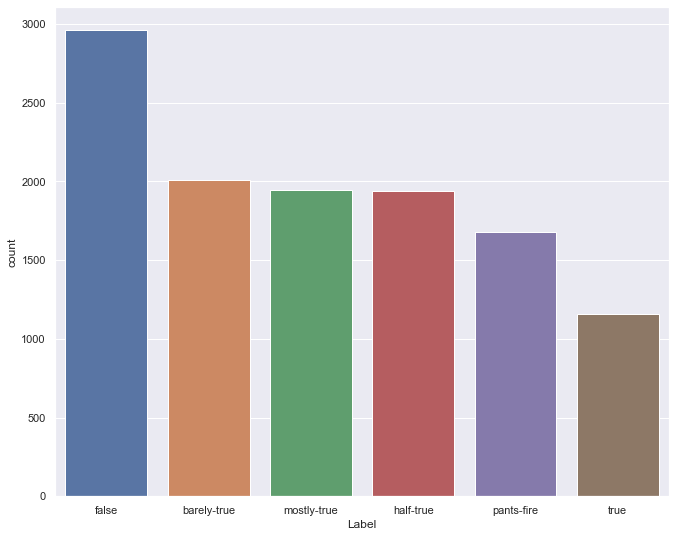

In [50]:
# Plot to visualize count of various news categories

plt.figure(figsize=[11,9])
sns.set(style='darkgrid')
sns.countplot(x='Label', data=df,order = df['Label'].value_counts().index)
plt.show()

In [51]:
# Splitting year from data column to visualize distribution of various categories of data over the year

df['Date'] = df['Date'].apply(lambda x: x.split(','))
df['Year'] = df['Date'].apply(lambda x: x[1])

C:\Users\Abhineet\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Abhineet\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



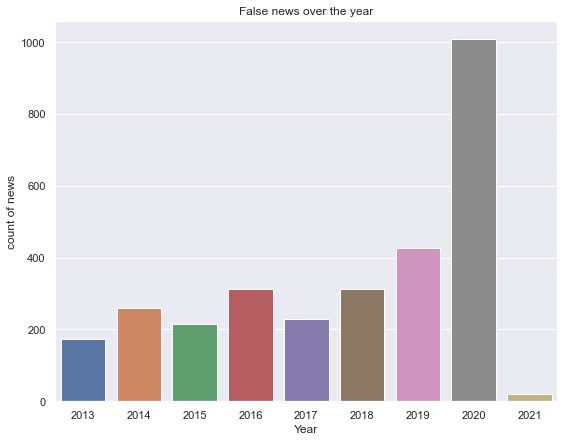

In [52]:
false_df = df[df['Label']=='false']
false_df['Year'] = pd.to_datetime(false_df['Year'])
false_df['year'] = false_df['Year'].astype('str').apply(lambda x : x.split("-")[0])
plt.figure(figsize=(9,7))
sns.countplot(x='year',data=false_df)
plt.xlabel('Year')
plt.ylabel('count of news')
plt.title('False news over the year')
plt.show()

C:\Users\Abhineet\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Abhineet\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



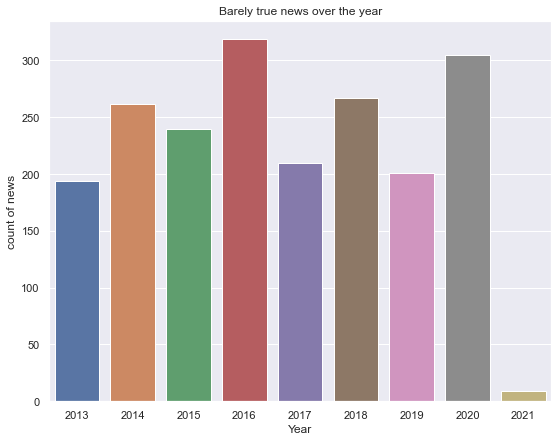

In [53]:
barelytrue_df = df[df['Label']=='barely-true']
barelytrue_df['Year'] = pd.to_datetime(barelytrue_df['Year'])
barelytrue_df['year'] = barelytrue_df['Year'].astype('str').apply(lambda x : x.split("-")[0])
plt.figure(figsize=(9,7))
sns.countplot(x='year',data=barelytrue_df)
plt.xlabel('Year')
plt.ylabel('count of news')
plt.title('Barely true news over the year')
plt.show()

C:\Users\Abhineet\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Abhineet\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



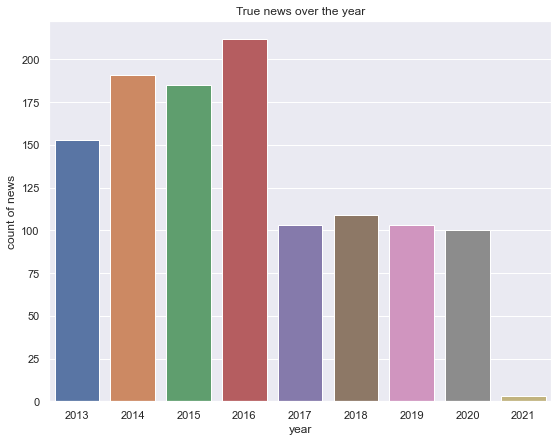

In [54]:
true_df = df[df['Label']=='true']
true_df['Year'] = pd.to_datetime(true_df['Year'])
true_df['year'] = true_df['Year'].astype('str').apply(lambda x : x.split("-")[0])
plt.figure(figsize=(9,7))
sns.countplot(x='year',data=true_df)
plt.xlabel('year')
plt.ylabel('count of news')
plt.title('True news over the year')
plt.show()

In [55]:
#Creating a dataframe after grouping the data on Label and Source

groupby_label = pd.DataFrame(df.groupby(['Label','Source'],as_index=False).count())
groupby_label

,Label,Source,Statement,Date,Year
0,barely-true,AFSCME,2,2,2
1,barely-true,Activist Mommy,1,1,1
2,barely-true,Adam Kinzinger,1,1,1
3,barely-true,Adam Putnam,3,3,3
4,barely-true,Adam Schnelting,1,1,1
...,...,...,...,...,...
4803,true,Wisconsin Department of Transportation,1,1,1
4804,true,Wisconsin Institute for Law & Liberty,1,1,1
4805,true,Wisconsin Transportation Builders Association,1,1,1
4806,true,Wolf Blitzer,1,1,1


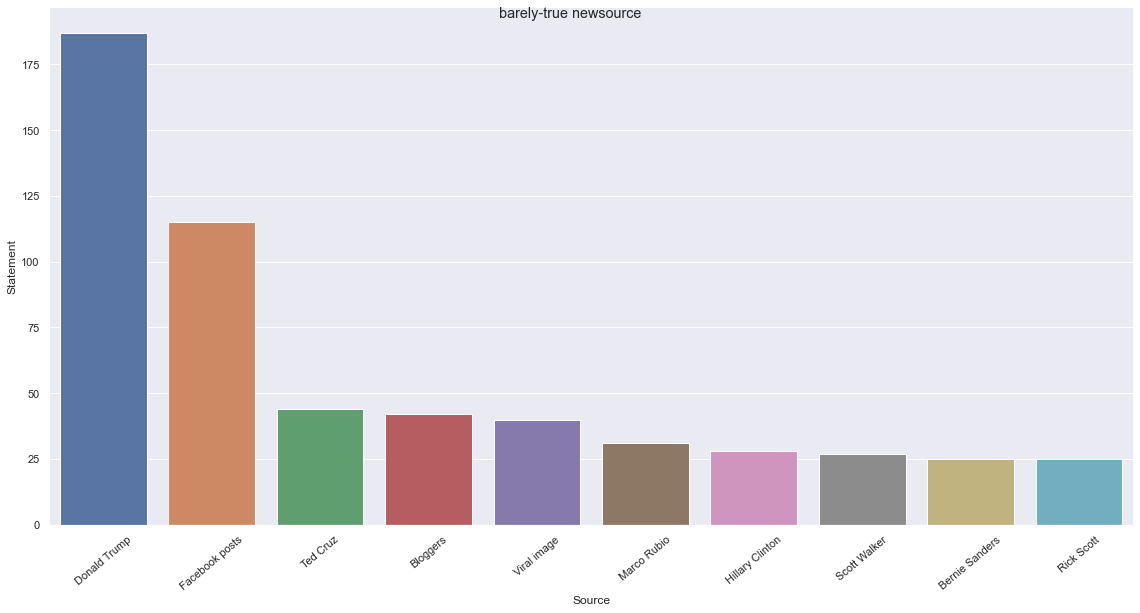

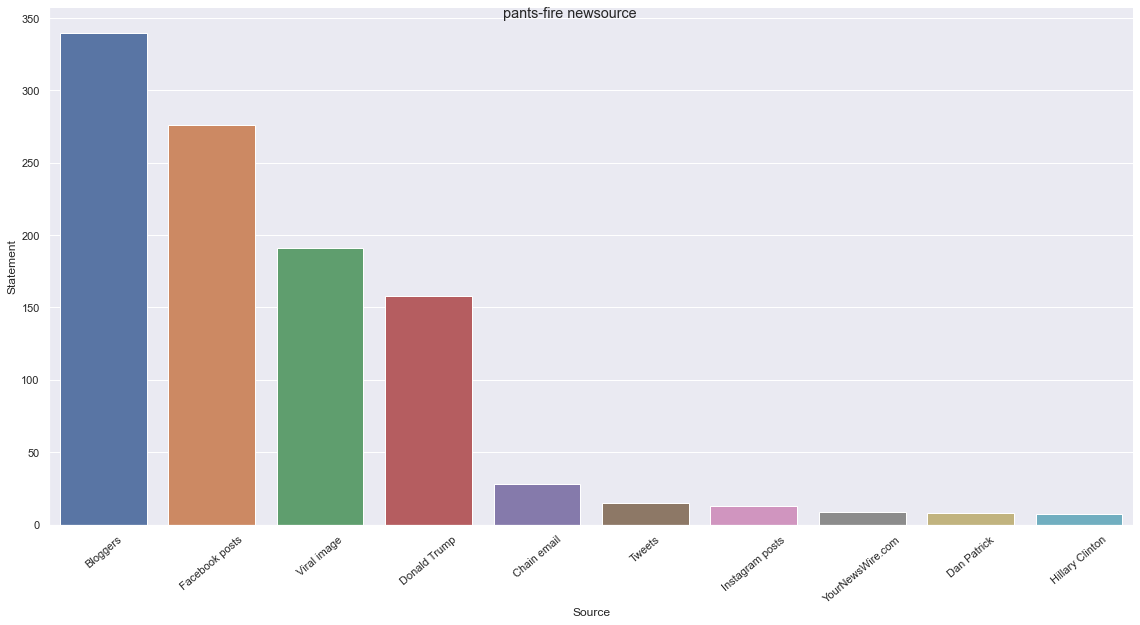

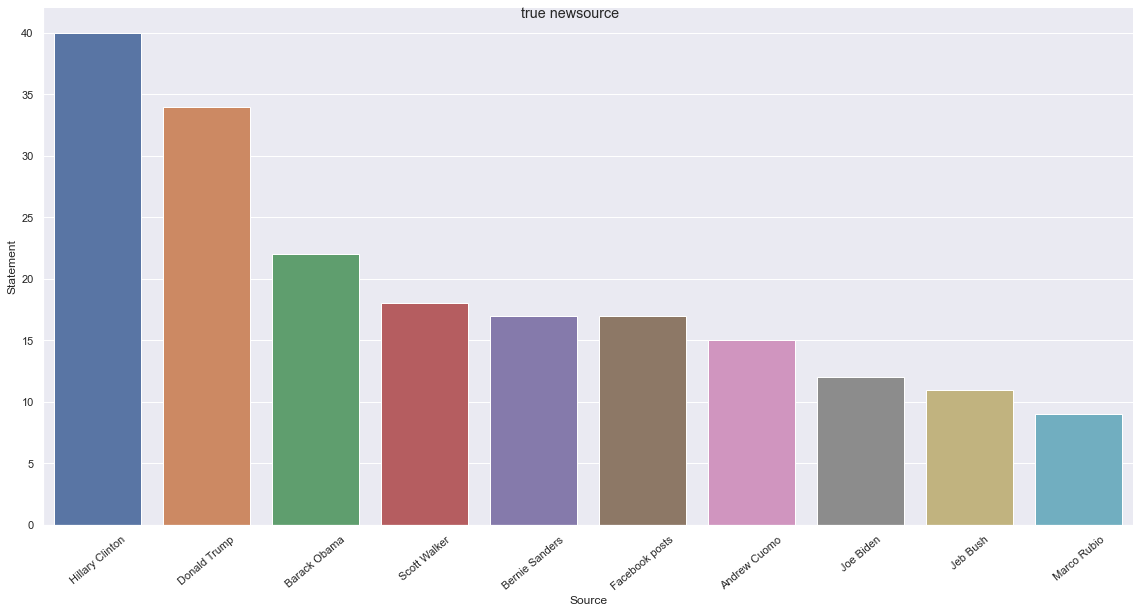

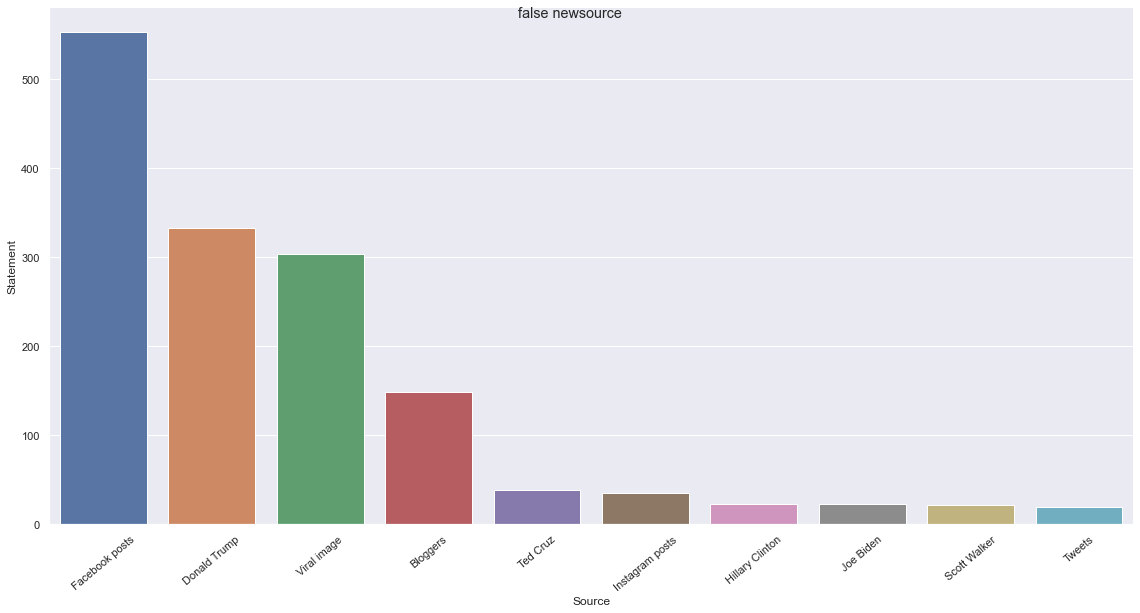

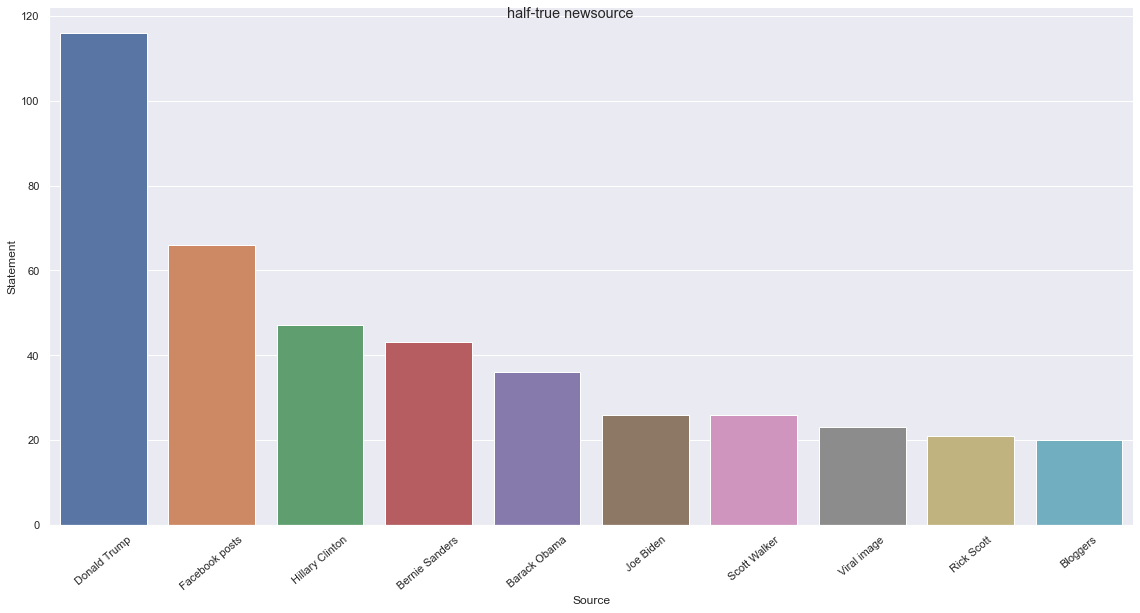

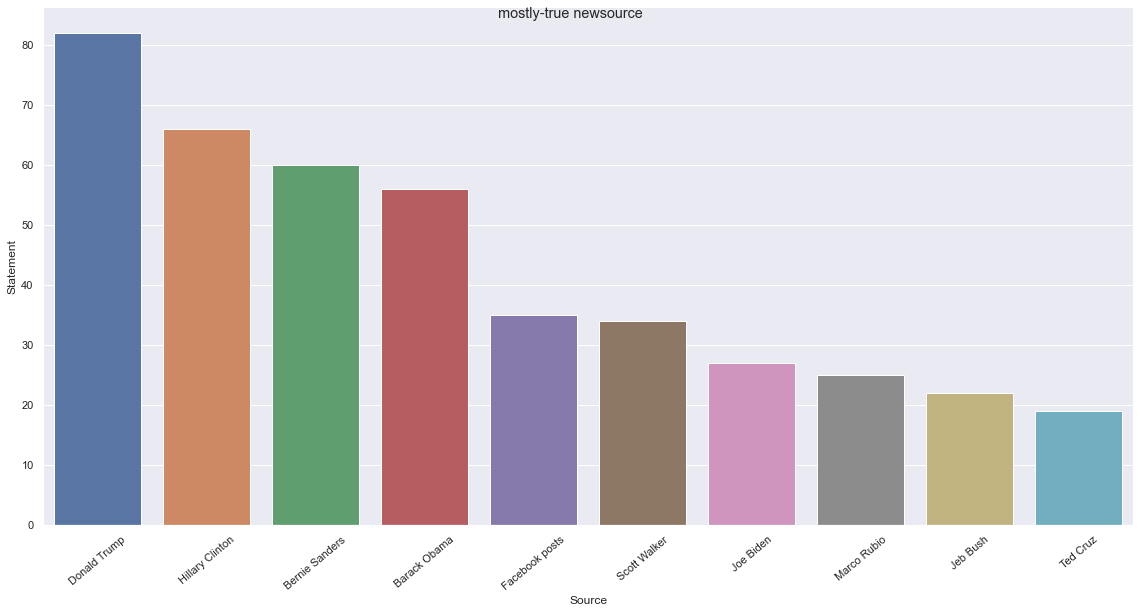

In [56]:
label = df.Label.unique()

for i in label:

    news_source = groupby_label[groupby_label['Label']==i].nlargest(10,'Statement')

    plot = sns.catplot(y='Statement', x='Source', data = news_source, kind='bar', aspect=2, height=8)    
    plot.set_xticklabels(rotation=40)
    plot.fig.suptitle(str(i)+' newsource')
    plt.show()

### Cleaning text for model building 

In [57]:
stop = set(stopwords.words('english'))
stop.update(punctuation)
stop.update(("’","'s","”","“","‘","–",'``',"Says","''"))
print(stop)

{"doesn't", 'which', 'these', 'why', 'his', 'y', 'because', 'there', 'doesn', "haven't", 'when', ')', 'them', 'below', 'while', 'didn', 'i', 'and', 'any', 'into', "won't", 'no', 'what', 'out', '~', 'nor', 'mustn', "you're", 'do', '.', "it's", 'again', '<', 'an', 'he', ':', ';', "you'll", '”', 'against', '/', '}', 'theirs', 'at', 'more', 'o', ']', 'has', '"', 'haven', '\\', 'mightn', "shan't", 'a', "'", 'does', 'themselves', "isn't", '&', 'to', 'yourself', '–', 'their', 'me', 'aren', "shouldn't", 'yours', 'that', 'am', 'being', 'with', 'very', 'isn', '!', "aren't", "needn't", ',', '-', 'ain', "'s", 'itself', "couldn't", "wasn't", "should've", 'wasn', 'those', '@', 'between', 'by', 'myself', 'your', 'hasn', 'until', "mustn't", 'who', '’', 'through', 'both', 'be', "don't", 'did', 'few', 'm', 'll', 'have', 'some', 'hadn', 'each', "hasn't", 'having', 'how', 't', 'just', 'too', 'him', 'are', 'not', '|', 'off', '_', '^', 'this', 'ours', 'himself', 'up', 'where', '“', 'she', "she's", 'of', '$'

In [58]:
# Function to clean text

lemmatizer = WordNetLemmatizer()
def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            new_w = lemmatizer.lemmatize(w)
            clean_text.append(new_w)
    return clean_text

def join_text(text):
    return " ".join(text)

In [59]:
df.Statement = df.Statement.apply(clean_review)
df.Statement = df.Statement.apply(join_text)

### Visualizing various categories of news and the frequent words present

In [60]:
true_df

,Statement,Date,Source,Label,Year,year
3,"""This election actually was not unusually close.""","[nuary 8, 2021]",Mitch McConnell,true,2021-01-01,2021
7,"In more than 60 cases, judges “looked at the a...","[nuary 8, 2021]",Joe Biden,true,2021-01-01,2021
45,“Congress has one job here: to count electoral...,"[nuary 4, 2021]",Mike Gallagher,true,2021-01-01,2021
50,"“In my state, as in many other states, we have...","[mber 30, 2020]",Pat Toomey,true,2020-01-01,2020
67,“Jurisdictions representing about 80% of WI re...,"[mber 21, 2020]",Chris Larson,true,2020-01-01,2020
...,...,...,...,...,...,...
11785,"Says ""94 percent of (Marco Rubio's) constituen...","[April 2, 2013]",Mark Kelly,true,2013-01-01,2013
11794,"""In 2011 alone, 269 New Jerseyans were killed ...","[arch 31, 2013]",Sheila Oliver,true,2013-01-01,2013
11799,"Says she has bipartisan support, including ""53...","[arch 29, 2013]",Patience Roggensack,true,2013-01-01,2013
11813,"Says ""PPS employees have paid their own PERS c...","[arch 26, 2013]",Portland Public Schools,true,2013-01-01,2013


In [61]:
import collections

df['temp'] = df['Statement'].apply(lambda x:str(x).split())
top = collections.Counter([item for sublist in df['temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp = temp[(temp.Common_words!= "Says")]
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,year,1094
2,Trump,935
3,percent,923
4,people,865
5,state,814
6,tax,773
7,million,613
8,Obama,584
9,said,530
10,President,510


In [62]:
import plotly.express as px

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Statement', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [63]:
true = df[df['Label']== 'true']

# MosT common words in True labelled news
top = collections.Counter([item for sublist in true['temp'] for item in sublist])
temp_true = pd.DataFrame(top.most_common(21))
temp_true.columns = ['Common_words','count']
temp_true = temp_true[(temp_true.Common_words!= "Says")]
temp_true.style.background_gradient(cmap='Greens')

,Common_words,count
1,year,165
2,percent,148
3,state,133
4,tax,75
5,Trump,70
6,people,70
7,one,68
8,Texas,63
9,time,58
10,million,58


In [64]:
fig = px.bar(temp_true, x="count", y="Common_words", title='Most Commmon Words present in True news', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [65]:
fake = df[df['Label']== 'false']

#MosT common positive words
top = collections.Counter([item for sublist in fake['temp'] for item in sublist])
temp_fake = pd.DataFrame(top.most_common(21))
temp_fake.columns = ['Common_words','count']
temp_fake = temp_fake[(temp_fake.Common_words!= "Says")]
temp_fake.style.background_gradient(cmap='Reds')

,Common_words,count
1,Trump,278
2,people,224
3,year,191
4,said,155
5,show,154
6,President,146
7,tax,146
8,Obama,141
9,state,137
10,Biden,130


In [66]:
fig = px.bar(temp_fake, x="count", y="Common_words", title='Most Commmon Words present in False news', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Visalizing word cloud for true and false news 

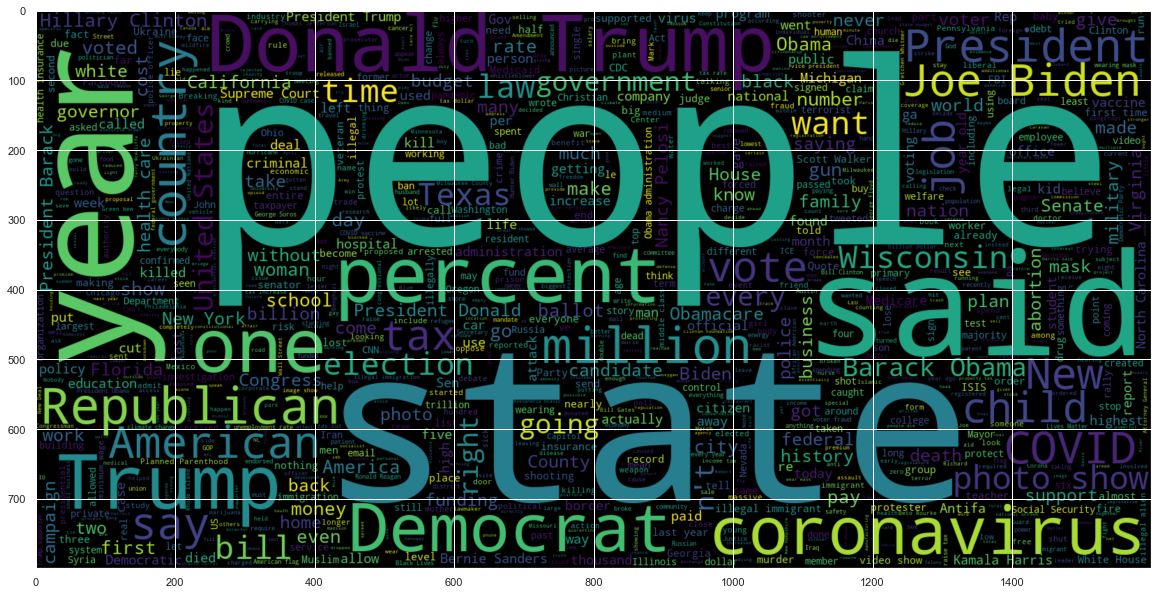

In [67]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stop_words = ['Says']+list(STOPWORDS)

plt.figure(figsize = (20,20)) 
word_cld = WordCloud(max_words = 1000 ,contour_color= 'Yellow', width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(fake.Statement))
plt.imshow(word_cld , interpolation = 'bilinear')
plt.show()

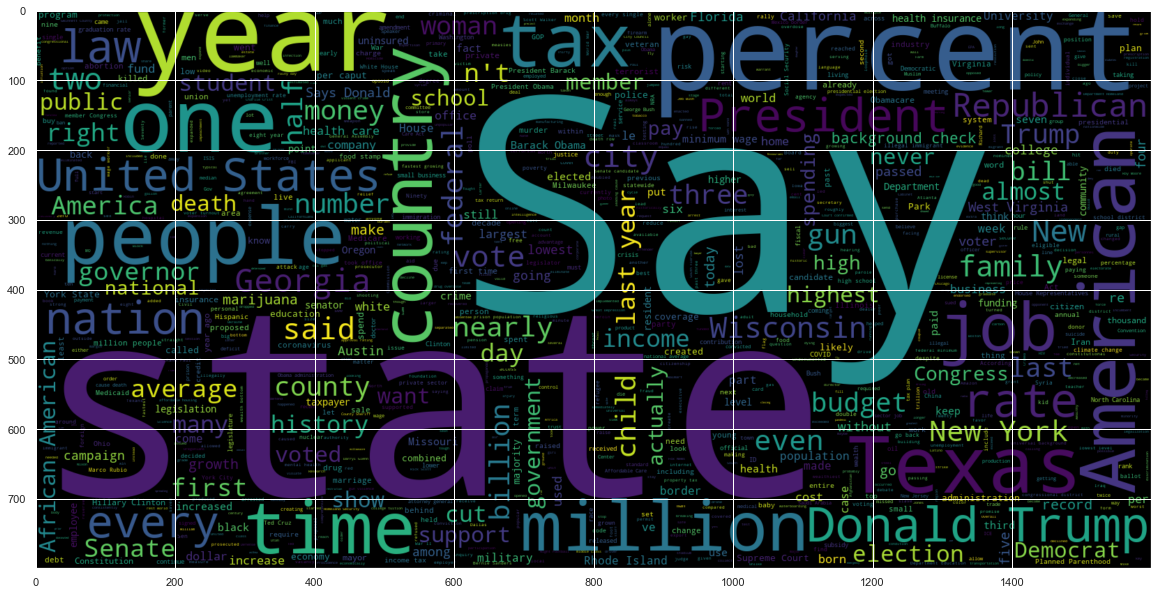

In [68]:
stop_wordss = ['Says'+'percent'+"Say"+'State']+list(STOPWORDS)

plt.figure(figsize = (20,20))
word_cld_1 = WordCloud(max_words = 1000 ,contour_color= 'Yellow', width = 1600 , height = 800 , stopwords = stop_wordss).generate(" ".join(true.Statement))
plt.imshow(word_cld_1 , interpolation = 'bilinear')
plt.show()

In [69]:
# Function to produce ngrams words visuals

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

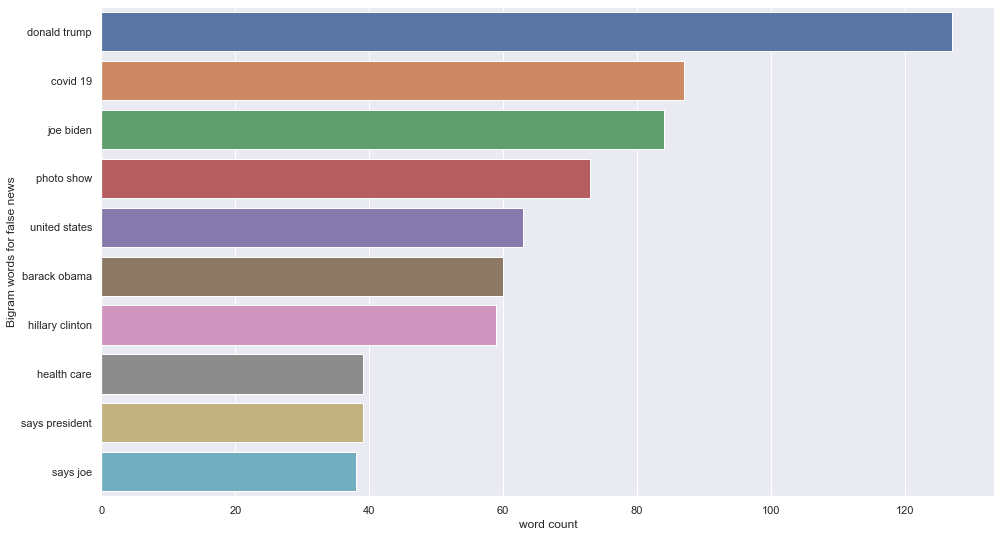

In [70]:
# Bigrams for fake news

plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(fake.Statement,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.xlabel('word count')
plt.ylabel("Bigram words for false news")
plt.show()

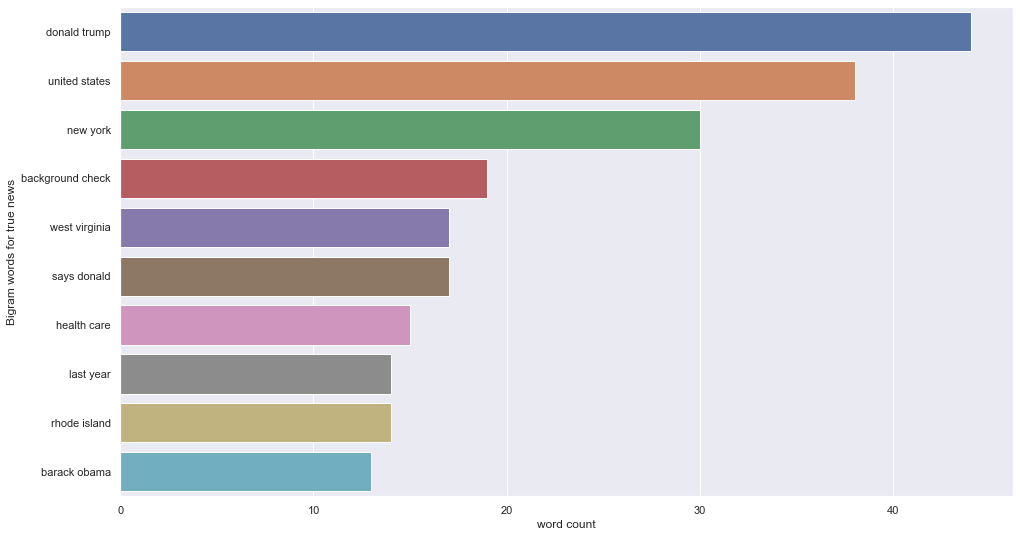

In [71]:
# Bigrams for True news


plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(true.Statement,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.xlabel('word count')
plt.ylabel("Bigram words for true news")
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

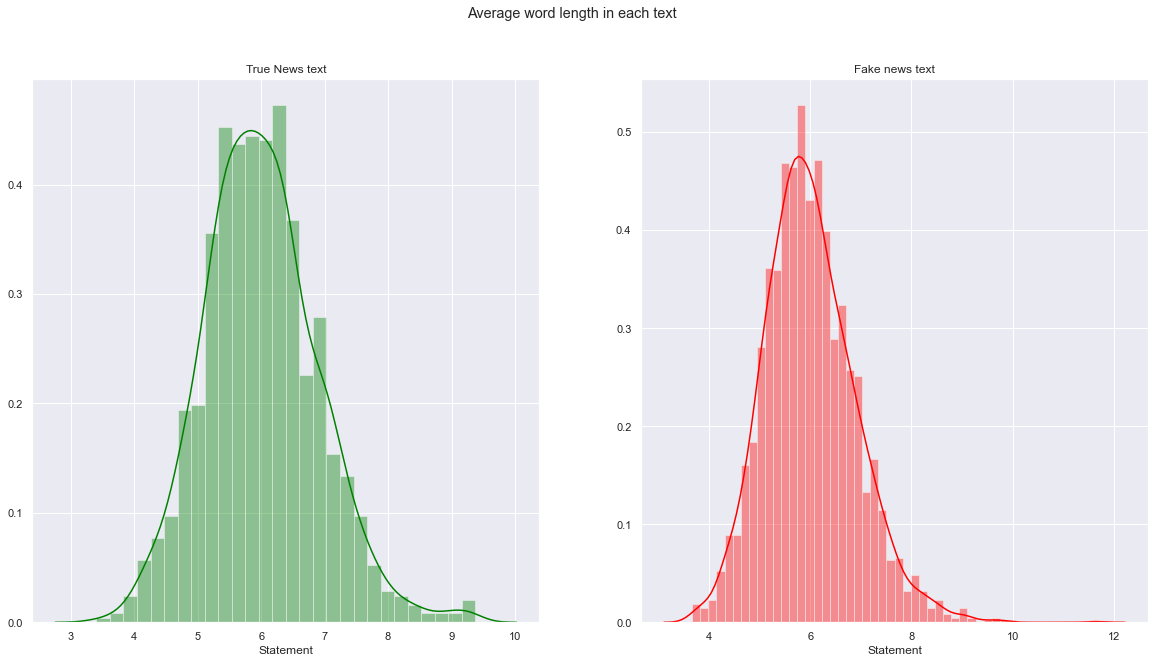

In [72]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['Label']=='true']['Statement'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('True News text')
word_1=df[df['Label']=='false']['Statement'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word_1.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake news text')
fig.suptitle('Average word length in each text')

In [73]:
df['Label'] = df['Label'].replace({'false':0,'barely-true':1, 'mostly-true':2,'half-true':3,'pants-fire':4,'true':5})

### Model Building 

In [75]:
X = df['Statement']
y = df['Label']

In [76]:
# Splitting the data in 80:20 split for train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [77]:
count_vec = CountVectorizer(max_features=50)


In [78]:
x_train_features = count_vec.fit_transform(X_train).todense()
x_test_features = count_vec.transform(X_test).todense()

In [79]:
from sklearn.multiclass import OneVsRestClassifier

logstcre = LogisticRegression()
ovr = OneVsRestClassifier(logstcre)

ovr.fit(x_train_features, y_train)
predicted_lr = ovr.predict(x_test_features)
print("LogisticRegression classification chart:\n",classification_report(y_test, predicted_lr))

LogisticRegression classification chart:
               precision    recall  f1-score   support

           0       0.29      0.76      0.42       590
           1       0.25      0.09      0.13       400
           2       0.24      0.25      0.25       372
           3       0.23      0.11      0.15       380
           4       0.33      0.06      0.11       331
           5       0.21      0.02      0.03       265

    accuracy                           0.28      2338
   macro avg       0.26      0.22      0.18      2338
weighted avg       0.26      0.28      0.21      2338



In [80]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=20)

rf_clf.fit(x_train_features, y_train)
predicted_rf = rf_clf.predict(x_test_features)

print("Random forest classification chart:\n",classification_report(y_test, predicted_rf))

Random forest classification chart:
               precision    recall  f1-score   support

           0       0.30      0.59      0.40       590
           1       0.19      0.13      0.15       400
           2       0.18      0.18      0.18       372
           3       0.25      0.16      0.20       380
           4       0.18      0.09      0.12       331
           5       0.23      0.09      0.13       265

    accuracy                           0.25      2338
   macro avg       0.22      0.21      0.20      2338
weighted avg       0.23      0.25      0.22      2338



In [81]:
nb_clf = MultinomialNB()
nb_clf.fit(x_train_features, y_train)
#print(nb_clf.score(x_train_features, train_result))
y_pred = nb_clf.predict(x_test_features)
print("MultinomialNB Classification chart", classification_report(y_test, y_pred))

MultinomialNB Classification chart               precision    recall  f1-score   support

           0       0.30      0.67      0.42       590
           1       0.27      0.10      0.14       400
           2       0.23      0.30      0.26       372
           3       0.23      0.09      0.13       380
           4       0.22      0.13      0.17       331
           5       0.21      0.05      0.07       265

    accuracy                           0.27      2338
   macro avg       0.24      0.22      0.20      2338
weighted avg       0.25      0.27      0.22      2338



In [90]:
y_pred

array([0, 0, 2, ..., 4, 3, 2], dtype=int64)